# OMEGA Userguide

* Execute cell by typing Shift+Enter.

* The circle at the top-right corner is filled when the code is running.

* If the notebook is stuck, restart the kernel (Kernel > Restart in the menu bar) or close and re-open the notebook.

##Introduction

OMEGA (One-zone Model for the Evolution of Galaxies) is a classical galactic chemical evolution model with an input star formation history where stars form and inject new elements within the same gas reservoir, using SYGMA (Stellar Yields for Galactic Modeling Applications) to create a simple stellar population at each timestep.  We highly recommend to consult the SYGMA userguide notebook before using OMEGA.  All the input parameters used by SYGMA to describe simple stellar populations can also be used by OMEGA.

This notebook presents a few exemples of how OMEGA can be used (see also [Côté et al. 2016](http://adsabs.harvard.edu/abs/2016arXiv160407824C)).  We refer to the Sphinx documentation for detailed information (<a href="http://nugrid.github.io/NuPyCEE/SPHINX/build/html/sygma.html">SYGMA</a>, <a href="http://nugrid.github.io/NuPyCEE/SPHINX/build/html/omega.html">OMEGA</a>).  The code offers both the closed box and the open box scenarios.  As shown below, three implementation options are available for the treatment of gas inflows and outflows.  Throughout this notebook, abundances ratios are presented in the following notation :

$$[A/B]=\log(n_A/n_B)-\log(n_A/n_B)_\odot.$$

**Import the OMEGA module**

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import omega
reload(omega)

<module 'omega' from '/Users/benoitcote/Desktop/OMEGA_SYGMA_inheritance/omega.pyc'>

##1. Closed Box Model (default mode)

A single-zone closed-box model solves the following equation at each timestep:

$$M_{\rm gas}(t+\Delta t)=M_{\rm gas}(t) + \Big[\dot{M}_{\rm ej}(t) - \dot{M}_\star(t)\Big]\Delta t,\qquad\qquad(1)$$

where $\Delta t$ is the duration of the timestep and $M_{\rm gas}(t)$, $\dot{M}_{\rm ej}(t)$, $\dot{M}_\star(t)$ are respectively the mass of the gas reservoir, the stellar mass loss rate, and the star formation rate (SFR) at time $t$.  Because the star formation history (SFH) is an input parameter and the mass ejected by stars is calculated with SYGMA from a set of stellar yields, the only unkown in that last equation is the mass of gas.

Let's simulate two galaxies with a constant SFR using the **cte_sfr** parameter in units of M$_\odot$ yr$^{-1}$.  The mass of the gas reservoir can be set by the **mgal** parameter in units of M$_\odot$.  Numerical predictions can afterward be visualized with the *plot_spectro* function.  Most of the plotting functions called by SYGMA can also be called by OMEGA.

In [3]:
# Modifying the mass of gas changes the metal concentration
o  = omega.omega(cte_sfr=1.0, mgal=1.5e10)
oo = omega.omega(cte_sfr=1.0, mgal=3.0e10)

OMEGA run in progress..
   OMEGA run completed - Run time: 1.54s
OMEGA run in progress..
   OMEGA run completed - Run time: 1.49s


<IPython.core.display.Javascript object>


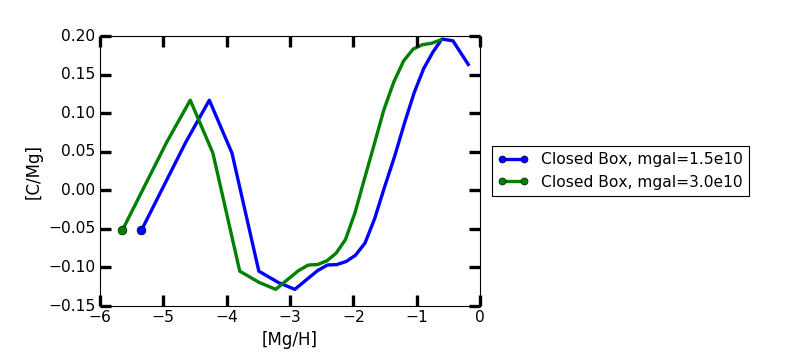

In [4]:
# Chose your X and Y axis
%matplotlib nbagg
x = '[Mg/H]'
y = '[C/Mg]'
o.plot_spectro( xaxis=x, yaxis=y, label='Closed Box, mgal=1.5e10', color='b')
oo.plot_spectro(xaxis=x, yaxis=y, label='Closed Box, mgal=3.0e10', color='g')

##2. Open Box Models

An single-zone open-box model solves the following equation at each timestep:

$$M_{\rm gas}(t+\Delta t)=M_{\rm gas}(t) + \Big[\dot{M}_{\rm in}(t) +\dot{M}_{\rm ej}(t) - \dot{M}_\star(t) - \dot{M}_{\rm out}(t)\Big]\Delta t,\qquad\qquad(2)$$

where $\dot{M}_{\rm in}(t)$ and $\dot{M}_{\rm out}(t)$ are the inflow and outflow rates at time $t$.  In the following sections, we present three different implementations that can be used to treat inflows and outflows.

###2.1. The IO Model

The IO model stands for inflow and outflow control.  It represents the most basis implementation for an open-box model, which makes it the easiest model to work with.  As for the closed-box model, the **mgal** parameter is used to set the initial mass of the gas reservoir.

####2.1.1. Constant Inflows and Outflows

Inflow and outflow rates can be set manually to a constant value in units of M$_\odot$ yr$^{-1}$ with the parameters **inflow_rate** and **outflow_rate**.  Let's look at how inflows and outflows modify the the gas content of a galaxy.

In [5]:
# Closed box
o_cl_box = omega.omega(mgal=1e10, cte_sfr=1.0)

# Semi-open box with inflows only
o_no_out = omega.omega(in_out_control=True, mgal=1e10, cte_sfr=1.0, inflow_rate=2.0, outflow_rate=0.0)

# Open box with inflows and outflows
o_in_out = omega.omega(in_out_control=True, mgal=1e10, cte_sfr=1.0, inflow_rate=2.0, outflow_rate=1.0)

OMEGA run in progress..
   OMEGA run completed - Run time: 1.54s
OMEGA run in progress..
   OMEGA run completed - Run time: 1.57s
OMEGA run in progress..
   OMEGA run completed - Run time: 1.55s


<IPython.core.display.Javascript object>


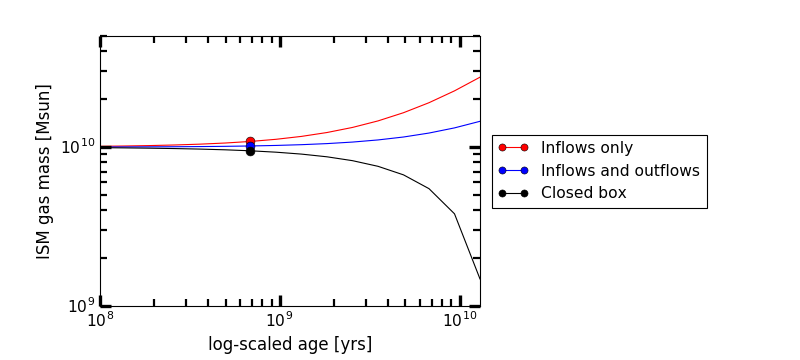

(1000000000.0, 50000000000.0)

In [6]:
# Plot the mass of the gas reservoir as a function of time
%matplotlib nbagg
o_no_out.plot_totmasses(color='r', label='Inflows only')
o_in_out.plot_totmasses(color='b', label='Inflows and outflows')
o_cl_box.plot_totmasses(color='k', label='Closed box')

# Set Y axis ranges
plt.xlim(1e8,13e9)
plt.ylim(1e9,5e10)

####2.1.2. Mass Loading Factor

When the SFH is not constant with time, it is preferable to use the relationship between the outflow rate and the SFR (e.g., <a href="http://adsabs.harvard.edu/abs/1999ApJ...513..156M">Martin 1999</a>; <a href="http://adsabs.harvard.edu/abs/2005ARA%26A..43..769V">Veilleux et al. 2005</a>),

$$\dot{M}_{\rm out}\equiv\eta\dot{M}_\star,\qquad\qquad(3)$$

where $\eta$ is the mass-loading factor, which can be set with the **mass_loading** parameter.  If this last parameter is used, the inflow rate can also be linked to the SFR by defining the ratio between inflows and outflows with the **in_out_ratio** parameter.  Here is an exemple with a SFH similar to the Sculptor dwarf spheroidal galaxy.

In [7]:
# Define the SFH input file
sfh = 'sculptor_data/sfh_deBoer12.txt'
# Any other SFH can be used as long as the 1st and 2nd 
# columns of the file are respectively the galactic age
# in yr and the SFR in Mo/yr.

# Define the final stellar mass
# The input SFH will be re-normalized
ms = 5.0e9

# Define the current stellar mass
o1 = omega.omega(in_out_control=True,stellar_mass_0=ms,sfh_file=sfh,mgal=1.0e10,in_out_ratio=1.0,mass_loading=1.0)
o2 = omega.omega(in_out_control=True,stellar_mass_0=ms,sfh_file=sfh,mgal=1.0e10,in_out_ratio=1.0,mass_loading=25.0)
o3 = omega.omega(in_out_control=True,stellar_mass_0=ms,sfh_file=sfh,mgal=1.0e10,in_out_ratio=2.0,mass_loading=25.0)

OMEGA run in progress..
   OMEGA run completed - Run time: 1.55s
OMEGA run in progress..
   OMEGA run completed - Run time: 1.56s
OMEGA run in progress..
   OMEGA run completed - Run time: 1.53s


<IPython.core.display.Javascript object>


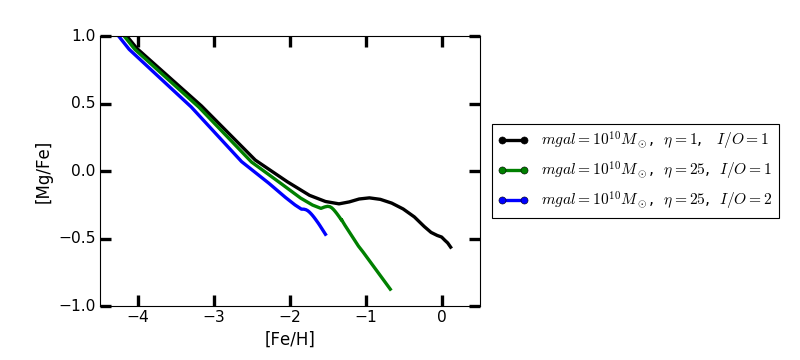

<IPython.core.display.Javascript object>


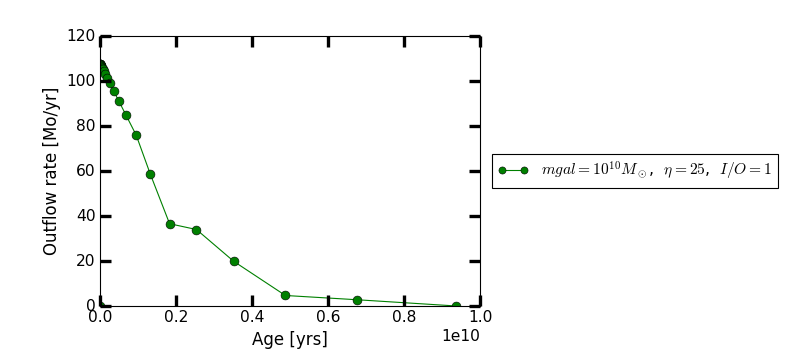

In [9]:
# Chose your X and Y axis
%matplotlib nbagg
x = '[Fe/H]'
y = '[Mg/Fe]'

# Plot predictions
o1.plot_spectro(xaxis=x, yaxis=y, color='k', label='$mgal=10^{10} M_\odot$,  $\eta=1$,   $I/O=1$')
o2.plot_spectro(xaxis=x, yaxis=y, color='g', label='$mgal=10^{10} M_\odot$,  $\eta=25$,  $I/O=1$')
o3.plot_spectro(xaxis=x, yaxis=y, color='b', label='$mgal=10^{10} M_\odot$,  $\eta=25$,  $I/O=2$')

# Set the X and Y axis ranges
plt.ylim(-1.0,1.0)
plt.xlim(-4.5,0.5)

# Plot the outflow rates
o2.plot_outflow_rate(color='g', label='$mgal=10^{10} M_\odot$,  $\eta=25$,  $I/O=1$')

###2.2. The SF Model

The SF model stands for star formation law.  Instead of defining the initial mass of gas, the following equation is used to calculate the mass of gas at each time $t$ (e.g., <a href="http://adsabs.harvard.edu/abs/2006RPPh...69.3101B">Baugh 2006</a>; <a href="http://adsabs.harvard.edu/abs/2015ARA%26A..53...51S">Somerville & Davé 2015</a>),

$$\dot{M}_\star(t)=f_\star\frac{M_{gas}(t)}{\tau_\star},\qquad\qquad(4)$$

where $f_\star$ and $\tau_\star$ are the star formation efficiency and timescale.  These quantify are respectively set by the **sfe** and the **t_star** parameters.  With the SF model, the outflow rate is still defined by the **mass_loading** parameter.  The inflow rate, the only unknown quantity in equation (2), is calculated at each timestep.

In [10]:
# Instance of a SF model
# The star formation timescale t_star is in units of yr
o_sf = omega.omega(SF_law=True, cte_sfr=1.0, mass_loading=1.0, sfe=0.01, t_star=1.0e8)

OMEGA run in progress..
   OMEGA run completed - Run time: 1.56s


<IPython.core.display.Javascript object>


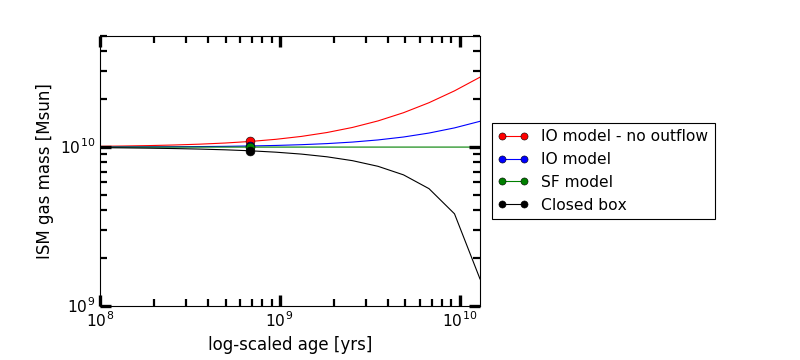

(1000000000.0, 50000000000.0)

In [11]:
# Plot the mass of gas as a function of time
%matplotlib nbagg
o_no_out.plot_totmasses(color='r', label='IO model - no outflow')
o_in_out.plot_totmasses(color='b', label='IO model')
o_sf.plot_totmasses(    color='g', label='SF model')
o_cl_box.plot_totmasses(color='k', label='Closed box')

# Set Y axis ranges
plt.xlim(1e8,13e9)
plt.ylim(1e9,5e10)

###2.3. The MA Model

The MA model stands for mass assembly, since the total mass of the galaxy is assumed to be increasing with time.  It still uses the star formation law presented in equation (4).  The total mass of a galaxy at time $t$, or the virial mass, is defined by

$$M_{\rm vir}(t)=M_{\rm gas}(t)+M_{\rm DM}(t)\approx M_{\rm DM}(t),\qquad\qquad(5)$$

where $M_{\rm DM}$ is the dark matter halo mass.  The MA model uses the relation derived by <a href="http://adsabs.harvard.edu/abs/2010MNRAS.406.2267F">Fakhouri et al. (2010)</a>, from the Millenium II cosmological N-body simulation (<a href="http://adsabs.harvard.edu/abs/2009MNRAS.398.1150B">Boylan-Kolchin et al. 2009</a>), to calculate the average mass inflow rate $\dot{M}_{DM}$ of dark matter as a function of $M_{\rm DM}$ and redshift ($z$),

$$\dot{M}_{DM}=46.1\left(\frac{M_{DM}}{10^{12}\mbox{M}_\odot}\right)^{1.1}(1+1.11z)\sqrt{\Omega_0(1+z)^3+\lambda_0}\quad\mbox{[M}_\odot\,\mbox{yr}^{-1}\mbox{]}.\qquad\qquad(6)$$

Here $\Omega_0$ adn $\lambda_0$ are the mass density and dark energy density parameters in the $\Lambda$CDM model (<a href="http://adsabs.harvard.edu/abs/2009ApJS..180..306D">Dunkley et al. 2009</a>).  Equation (6) is normalized by setting the final dark matter halo mass at the end of the simulation ($z=0$) with the **m_DM_0** parameter.

In [12]:
# Instance of a MA model
# The final dark matter halo mass is in units of solar mass
o_ma = omega.omega(DM_evolution=True, m_DM_0=1e11, mass_loading=25, sfe=0.01)

OMEGA run in progress..
   OMEGA run completed - Run time: 1.56s


<IPython.core.display.Javascript object>


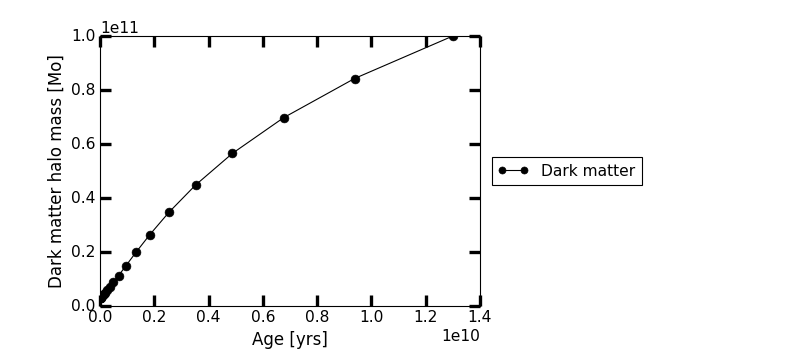

In [13]:
# Plot the mass of the dark matter halo as a function of time
%matplotlib nbagg
o_ma.plot_dark_matter()

####2.3.1 Evolving Mass Loading Factor

The mass-loading factor can be defined by (<a href="http://adsabs.harvard.edu/abs/2005ApJ...618..569M">Murray et al. 2005</a>)

$$\eta\propto v_{\rm out}^{-\gamma},\qquad\qquad(7)$$

where $v_{\rm out}$ is the velocity of the outflowing material and $\gamma$ a constant which can be set by the **exp_ml** parameter.  Observations suggest that $v_\mathrm{out}$ is proportional to the rotation speed of galaxies (<a href="http://adsabs.harvard.edu/abs/2005ApJ...621..227M">Martin 2005</a>), which is also proportional to the virial velocity $V_\mathrm{vir}$ of the host dark matter halo.  Considering the virial theorem and the assumption that halos form when their average density is 200 times larger than the average density of the Universe at the time of formation,

$$V_\mathrm{vir}(t)^2=\frac{GM_\mathrm{vir}(t)}{R_\mathrm{vir}(t)},\qquad\qquad(8)$$

$$R_\mathrm{vir}(t)\approx\left[\frac{3M_\mathrm{vir}(t)}{800\pi\bar{\rho}_0}\right]^{1/3}(1+z)^{-1},\qquad\qquad(9)$$

where $R_\mathrm{vir}$ is the virial radius of the dark matter halo.  By combining these three last equations, the mass loading factor becomes defined by

$$\eta(t)=C_\eta M_\mathrm{vir}(t)^{-\gamma /3}(1+z)^{-\gamma/2}.\qquad\qquad(10)$$

The code has a subroutine to convert the redshift into galactic age.  When using the MA model, the **mass_loading** parameter is still used, but it then refers to the final value at the end of the simulation.  From that information, the $C_\eta$ normalization constant is calculated.  We refer to <a href="http://adsabs.harvard.edu/abs/2012MNRAS.421.3522H">Hopkins et al. (2012)</a> and <a href="http://adsabs.harvard.edu/abs/2015arXiv150103155M">Muratov et al. (2015)</a> for alternative functions for the mass-loading factor.

<IPython.core.display.Javascript object>


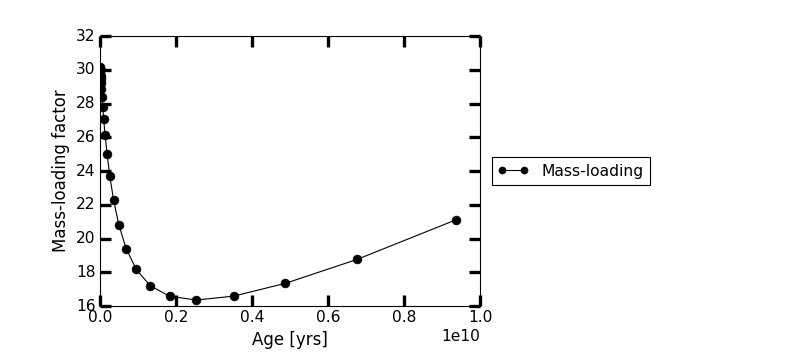

<IPython.core.display.Javascript object>


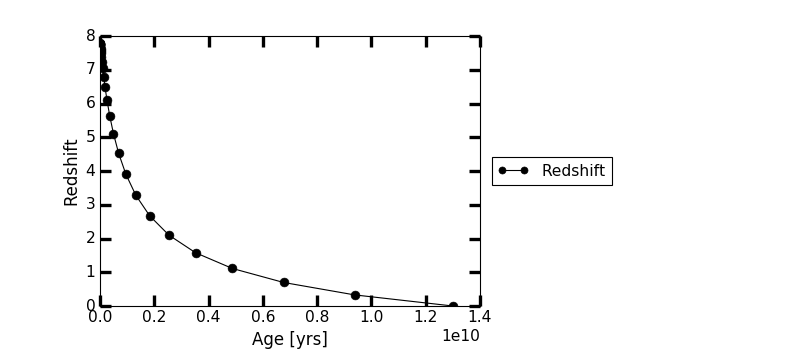

In [14]:
# Plot the mass loading factor as a function of time
%matplotlib nbagg
o_ma.plot_mass_loading()

# Plot the evolution of redshift as a function of time
o_ma.plot_redshift()

####2.3.2. Evolving Star Formation Timescale

With the MA model, the star formation timescale $\tau_\star$ is assumed to be proportional to the dynamical timescale $\tau_\mathrm{dyn}$ of the virialized system (e.g., <a href="http://adsabs.harvard.edu/abs/1999MNRAS.303..188K">Kauffmann et al. 1999</a>; <a href="http://adsabs.harvard.edu/abs/2000MNRAS.319..168C">Cole et al. 2000</a>; <a href="http://adsabs.harvard.edu/abs/2001MNRAS.328..726S">Springel et al. 2001</a>).  With $\tau_\mathrm{dyn}\approx~R_\mathrm{vir}/V_\mathrm{vir}$ and the relation for $R_\mathrm{vir}$ defined in <a href="http://adsabs.harvard.edu/abs/1991ApJ...379...52W">White & Frenk (1991)</a>,

$$R_\mathrm{vir}=0.1H_0^{-1}(1+z)^{-3/2}V_\mathrm{vir},\qquad\qquad(11)$$

where $H_0$ is the current Hubble constant, the star formation timescale is given by

$$\tau_\star=f_\mathrm{dyn}\tau_\mathrm{dyn}\approx0.1f_\mathrm{dyn}H_0^{-1}(1+z)^{-3/2}.\qquad\qquad(12)$$

The $f_{\rm dyn}$ constant can be set with the **f_dyn** parameter.  The star formation efficiency used in equation (4) can still be set by the **sfe** parameter.

<IPython.core.display.Javascript object>


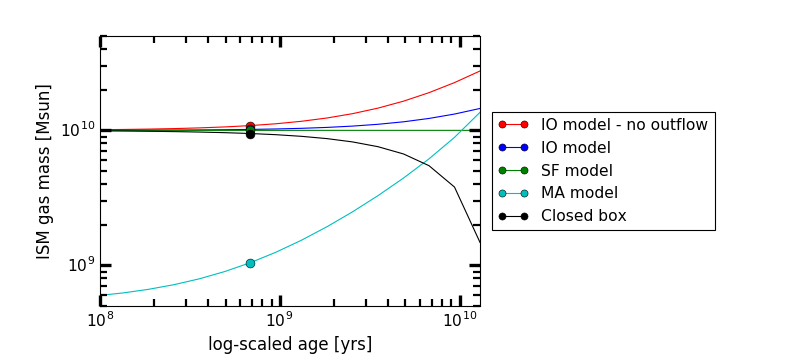

(500000000.0, 50000000000.0)

In [15]:
# Because the star formation timescale is evolving, the
# mass of gas is also evolving (see equation 4), which is
# not the case in the SF model.  
%matplotlib nbagg
o_no_out.plot_totmasses(color='r', label='IO model - no outflow')
o_in_out.plot_totmasses(color='b', label='IO model')
o_sf.plot_totmasses(    color='g', label='SF model')
o_ma.plot_totmasses(    color='c', label='MA model')
o_cl_box.plot_totmasses(color='k', label='Closed box')
plt.xlim(1e8,13e9)
plt.ylim(5e8,5e10)

##3. Simulating Local Galaxies

OMEGA can use the observed characteristics of known galaxies in order to reproduce their chemical evolution.  When selecting a known galaxy with the **galaxy** parameter, the code automatically loads the corresponding SFH, **stellar_mass_0**, and **m_DM_0**.  Here is a list of the current considered galaxies (see the Stellab module for observational stellar abundances data):


**Milky Way** (galaxy='milky_way')

* SFH : model of <a href="http://adsabs.harvard.edu/abs/2001ApJ...554.1044C">Chiappini et al. (2001)</a>
* Current stellar mass : 5 x 10$^{10}$ M$_\odot$ (<a href="http://adsabs.harvard.edu/abs/2006MNRAS.372.1149F">Flynn et al. 2006</a>; <a href="http://adsabs.harvard.edu/abs/2007ApJ...662..322H">Hammer et al. 2007</a>; <a href="http://adsabs.harvard.edu/abs/2011MNRAS.414.2446M">McMillan 2011</a>)
* Current dark matter mass : 1 x 10$^{12}$ M$_\odot$ (<a href="http://adsabs.harvard.edu/abs/2008ApJ...684.1143X">Xue et al. 2008</a>; <a href="http://adsabs.harvard.edu/abs/2011MNRAS.414.2446M">McMillan 2011</a>; <a href="http://adsabs.harvard.edu/abs/2015MNRAS.453..377W">Wang et al. 2015</a>)

**Sculptor** (galaxy='sculptor')

* SFH : <a href="http://adsabs.harvard.edu/abs/2012A%26A...539A.103D">de Boer et al. (2012a)</a>
* Current stellar mass : 7.8 x 10$^{6}$ M$_\odot$ (<a href="http://adsabs.harvard.edu/abs/2012A%26A...539A.103D">de Boer et al. 2012a</a>)
* Current dark matter mass : 1.5 x 10$^{9}$ M$_\odot$ (<a href="http://adsabs.harvard.edu/abs/2010MNRAS.408.2364S">Strigari et al. 2010</a>)


**Fornax** (galaxy='fornax')

* SFH : <a href="http://adsabs.harvard.edu/abs/2012A%26A...544A..73D">de Boer et al. (2012b)</a>
* Current stellar mass : 4.3 x 10$^{7}$ M$_\odot$ (<a href="http://adsabs.harvard.edu/abs/2012A%26A...544A..73D">de Boer et al. 2012b</a>)
* Current dark matter mass : 7.1 x 10$^{8}$ M$_\odot$ (<a href="http://adsabs.harvard.edu/abs/2010MNRAS.408.2364S">Strigari et al. 2010</a>)


**Carina** (galaxy='carina')

* SFH : <a href="http://adsabs.harvard.edu/abs/2014A%26A...572A..10D">de Boer et al. (2014)</a>
* Current stellar mass : 1.1 x 10$^{6}$ M$_\odot$ (<a href="http://adsabs.harvard.edu/abs/2014A%26A...572A..10D">de Boer et al. 2014</a>)
* Current dark matter mass : 3.4 x 10$^{6}$ M$_\odot$ (<a href="http://adsabs.harvard.edu/abs/2014A%26A...572A..10D">de Boer et al. 2014</a>; <a href="http://adsabs.harvard.edu/abs/2015NatCo...6E7599U">Ural et al. 2015</a>)

##4. Summary

Here is a summary of all the different options and their associated parameters.  The **cte_sfr**, **sfh_file**, and **stellar_mass_0** parameters can always be used when **galaxy** is not specified.

###Closed Box (default mode)

* **mgal** : initial mass of gas [M$_\odot$]

###IO Model (in_out_control=True)

  * **mgal** : initial mass of gas [M$_\odot$]
  * **inflow_rate** : constant mass inflow rate [M$_\odot$ yr$^{-1}$]
  * **outflow_rate** : constant mass outflow rate [M$_\odot$ yr$^{-1}$]
  * **mass_loading** : mass loading factor
  * **in_out_ratio** : ratio between the inflow and outflow rates

###SF Model (SF_law=True)

* **sfe** : star formation efficiency
* **t_star** : star formation timescale [yr]
* **mass_loading** : mass loading factor

###MA Model (DM_evolution=True)

* **sfe** : star formation efficiency
* **f_dyn** : fraction of the dynamical timescale representing the star formation timescale
* **mass_loading** : final value of the mass loading factor (at the end of the simulation)
* **exp_ml** : exponent value in the relation betwee $\eta$ and $v_{\rm out}$

##5. Contact

If you encounter any problem or if you have questions or comments, please contact Benoit Côté at <bcote@uvic.ca>.